In [6]:
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [3]:
# Load the Fashion MNIST dataset using torchvision
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

100%|██████████| 26421880/26421880 [00:06<00:00, 3981711.56it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 337485.88it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 848213.57it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14619009.47it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Define the preprocessing function
def preprocess(imgs):
    imgs = imgs.float() / 255.0  # Convert to float32 and normalize to [0, 1]
    imgs = torch.nn.functional.pad(imgs, (2, 2, 2, 2), mode='constant', value=0.0)  # Pad with 0s
    imgs = imgs.unsqueeze(1)  # Add channel dimension
    return imgs

# Extract and preprocess the data
x_train = preprocess(train_dataset.data)
x_test = preprocess(test_dataset.data)

# Extract labels
y_train = train_dataset.targets
y_test = test_dataset.targets

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_shape):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        # Calculating the flattened size after convolutions
        dummy_input = torch.zeros(1, *input_shape)
        self.flattened_size = self._get_flattened_size(dummy_input)
        self.fc = nn.Linear(self.flattened_size, 2)

    def _get_flattened_size(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Example usage
input_shape = (1, 32, 32)  # Example input shape for grayscale images of size 32x32
encoder = Encoder(input_shape)
print(encoder)


Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2048, out_features=2, bias=True)
)


2048

In [8]:

enc=Encoder(x_train[0].shape)
enc.flattened_size.size(1)

2048

# Autoencoder:<br>
Autoencoder is a neural network made up of two parts:
 * An `encoder` network that compresses high dimensional input data into a lower dimensional embedding vector
 * A `decoder` network that decompresses a given back to the original domain e.g., back to an image.

# Encoder Architecture
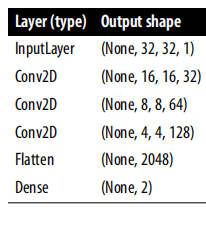

In [9]:
class Encoder(nn.Module):
  def __init__(self, input_shape):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels=32,
                           kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                           kernel_size=3, stride=2, padding=1)
    self.conv3=nn.Conv2d(in_channels=64, out_channels=128,
                         kernel_size=3, stride=2, padding=1)
    self.flatten=nn.Flatten()
    # calculate the flatten size after convolutions
    dummy_input=torch.zeros(1, *input_shape)
    self.flattened_size=self._get_flattened_size(dummy_input)

  def _get_flattened_size(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    return x.view(1,-1)
  def forward(self, x):
     x = F.relu(self.conv1(x))
     x = F.relu(self.conv2(x))
     x = F.relu(self.conv3(x))
     x = self.flatten(x)
     x = self.fc(x)
     return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.dense = nn.Dense()

TensorShape([2048])